# Example usage of Multi-region Sparse Component Analysis (mSCA)
- In order for `mSCA` to be imported properly, you will need to follow the installation instructions for the `sca` module located in the `readme` [here](https://github.com/glaserlab/sca)
- It's recommended to go through the `Example_1pop.ipynb` notebook before going through this one

### Import packages

In [1]:
import numpy as np
import numpy.random as npr
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.linalg import orth
import time

from sca.models import mSCA

# Create a simulated dataset
- Data is simulated from sparsely occurring latents

In [2]:
#Function that creates a sine wave for a given amount of time (T),
#where the number of cycles (c) occurs during that time
def create_sine(T,c):
    tau=T/(2*np.pi)/c
    return np.sin(np.arange(0,T)/tau)

### Simulate time-shifted and region-specific latent signals for 2 regions
- The following cell takes the sparsely occurring latents from the previous step and creates a new set of latents for two separate "neural" regions.
- The first and last of these latents will only occur in a particular region, making them region-specific.
- The other regions will have region-specific time-delays.
- We expect the time-delays to be captured by the means of the learned Gaussian filters in the mSCA model.
- We expect the region-specificity of each latent to be captured by the learned scaling of the Gaussian filters.

In [3]:
np.random.seed(0) #To get the same simulated data
%matplotlib inline

# Simulation parameters
T=920               # Time per "trial"
N_trials=10         # Number of "trials"
N_regions=2         # Number of brain regions
N_neurons=50        # Number of neurons per region
R_sim=5             # Number of dimensions in lowD representations
Max_timeshift=10    # Maximum timeshift

# Orthogonal matrix that projects low dimensional space to full neural space
V_tmp0=orth(npr.randn(R_sim,N_neurons).T).T
V_tmp1=orth(npr.randn(R_sim,N_neurons).T).T 

# Create low dimensional space
Z=np.zeros([T,R_sim])
for i in range(R_sim):
    Z[150*i:150*i+300,i]=create_sine(300,i+1)

# Create timeshifts
shifts=npr.randint(
    0,
    high=Max_timeshift,
    size=(R_sim,)
)

# Time-shift latents (this will only work for 2 regions right now)
Z0, Z1 = np.zeros_like(Z), np.zeros_like(Z)
for dim, shift in enumerate(shifts):
    if shift != 0:
        Z0[:-shift,dim] = Z[shift:,dim]
        Z1[shift:,dim] = Z[:-shift:,dim]
    else:
        Z0[:,dim] = Z[:,dim]
        Z1[:,dim] = Z[:,dim]

# Make the first and last dimension region-specific
Z0[:,-1], Z1[:,0] = 0, 0

### Generate "trials" by projecting shifted low-D latents up into high-D "neural" space
- We will pass the latents created for each region ``Z0`` and ``Z1`` through their respective portions of a random orthonormal matrix.
- In doing so, we are projecting the latents up into high-D "neural" space, which we will add noise to and give as inputs to the model.

In [4]:
X0_trials, X1_trials = [], []
for tri_num in range(N_trials):
    #Create high-dimensional neural activity for region #1    
    b0=npr.randn(N_neurons)                         #Offset of neurons
    X0=Z0@V_tmp0[:,:N_neurons]+b0                   #Project into high-dimensional space and add offset
    X0=X0+.1*npr.randn(X0.shape[0],X0.shape[1])     #Add noise
    X0_trials.append(X0)

    #Create high-dimensional neural activity for region #2
    b1=npr.randn(N_neurons)                         #Offset of neurons
    X1=Z1@V_tmp1[:,:N_neurons]+b1                   #Project into high-dimensional space and add offset
    X1=X1+.1*npr.randn(X1.shape[0],X1.shape[1])     #Add noise
    X1_trials.append(X1)

### Plot simulated data

Text(0.5, 1.0, 'Example simulated "neurons" \n from region 2')

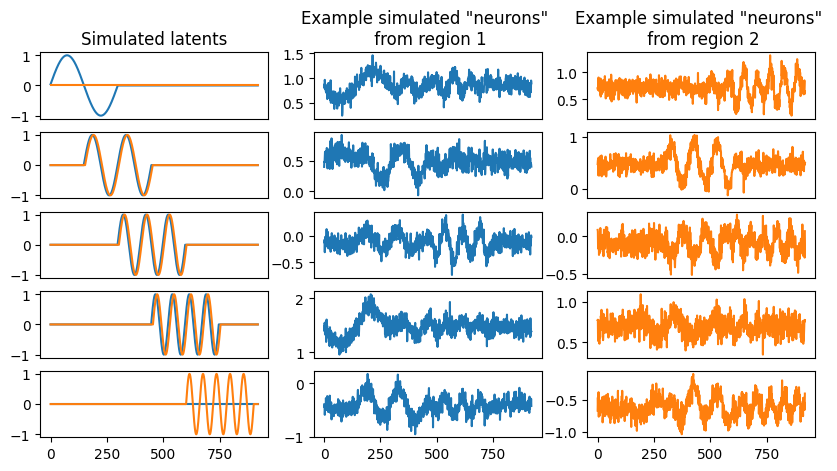

In [5]:
plt.figure(figsize=(10,5))
for i in range(R_sim):
    plt.subplot(R_sim, 3, (3*i)+1)
    plt.plot(Z0[:,i])
    plt.plot(Z1[:,i])

    if i < R_sim-1:
        plt.xticks([])

    plt.subplot(R_sim, 3, (3*i)+2)
    plt.plot(X0[:,i])

    if i < R_sim-1:
        plt.xticks([])

    plt.subplot(R_sim, 3, (3*i)+3)
    plt.plot(X1[:,i], c='#ff7f0e')

    if i < R_sim-1:
        plt.xticks([])

# Titles
plt.subplot(R_sim,3,1)
plt.title('Simulated latents')

plt.subplot(R_sim,3,2)
plt.title('Example simulated "neurons" \n from region 1')

plt.subplot(R_sim,3,3)
plt.title('Example simulated "neurons" \n from region 2')

# Data formatting
- The input to mSCA should be a dictionary
    - The keys are the names of the regions (e.g. `X0` and `X1`)
    - The values are lists, wh
    ere each entry is a `numpy` array representing a trial
        - The value can also be a single `numpy` array, that's not in a list
    - Each `numpy` array should have `time` rows and `neurons` columns i.e. the shape should be `[time, neurons]`  

In [6]:
# Make a dictionary to demarcate regions
X = {
    'X0': X0_trials,
    'X1': X1_trials
}

# Train the model to recover the ground-truth latents and filters
- The following cell will train the mSCA model and return the latent representations learned from our noisy high-D "neural" data.
- Notes on hyperparameter settings:
    - `lam_sparse` controls the level of sparsity in the learned latent representations. Increasing `lam_sparse` will reduce the level of noise in your learned latent representations, at the cost of reconstruction quality. We've found that values in the range of `0.10` and `0.50` work generally well across datasets.
    - `lam_orthog` controls the orthogonality of the learned latent dimensions. We've found that setting this to a relatively small value, such as `0.01` produces the best results.
    - `filter_length` represents the total width of the learned filters. This should always be an odd number. This should be greater than or equal the maximum time-delay you expect to see between the brain regions you running the model on.
    - `n_epochs` controls the number of iterations the model will iterate through the entire dataset. This should be set high enough such that the loss stored in `msca.losses` clearly converges.
    - `n_components` controls the number of latent dimensions.

In [7]:
from sca.models import mSCA

msca = mSCA(
    n_components=R_sim,
    filter_length=41,
    n_epochs=2000,
    lam_sparse=0.5,
    lam_orthog=0.01
)

latent = msca.fit_transform(X)

Using device cpu
Only using orthog penalty, not constraint


100%|██████████| 2000/2000 [08:29<00:00,  3.92it/s]


### Plot the losses from training mSCA

Text(0, 0.5, 'Loss')

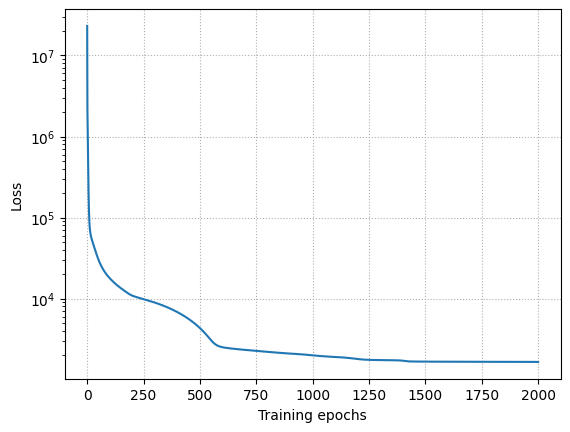

In [8]:
plt.plot(msca.losses)
plt.yscale("log")
plt.grid(linestyle=":")
plt.xlabel("Training epochs")
plt.ylabel("Loss")

### Plot the unordered latents for a single trial and their corresponding filters

Text(0.5, 1.0, 'Learned Gaussian filters for each region ')

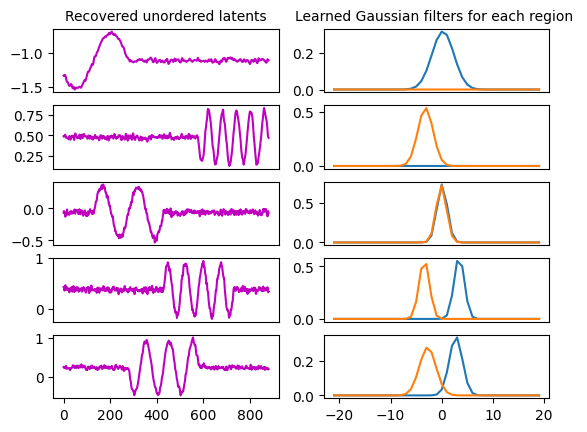

In [9]:
z_trial_0 = latent[0]
x_vals, filters = msca.model.plottable_filters()

j=0
for i in range(R_sim):
    plt.subplot(R_sim, 2, j+1)
    plt.plot(z_trial_0[:,i], c='m')
    if i < R_sim-1:
        plt.xticks([])

    plt.subplot(R_sim, 2, j+2)
    plt.plot(x_vals, filters[0][i].squeeze().detach().numpy())
    plt.plot(x_vals, filters[1][i].squeeze().detach().numpy())
    if i < R_sim-1:
        plt.xticks([])
    j+=2

# Titles
plt.subplot(R_sim,2,1)
plt.title('Recovered unordered latents', fontsize=10)

plt.subplot(R_sim,2,2)
plt.title('Learned Gaussian filters for each region ', fontsize=10)


## Final notes
- The performance metric functionality described at the bottom of `Example_1pop.ipynb` is supported by the `mSCA` as well
    - You can call `Xhat = msca.reconstruct(X)` to get reconstructions of the inputs `X`. Note that `Xhat` will be in the same format as `X` - a dict of lists containing `numpy` arrays.
    - You can also access performance metrics such as `r2_score`, `reconstruction_loss`, and `explained_squared_activity` as attributes of the `mSCA` model, after training e.g. `msca.reconstruction_loss`.